In [9]:
#export
from torch import tensor
import numpy as np
import pandas as pd


In [30]:
#export
import matplotlib.pyplot as plt

In [6]:
#export
import PIL

In [7]:
import sys
!{sys.executable} -m pip install opencv-python

    100% |████████████████████████████████| 52.1MB 257kB/s ta 0:00:011    43% |█████████████▉                  | 22.5MB 1.3MB/s eta 0:00:23    71% |███████████████████████         | 37.3MB 1.6MB/s eta 0:00:10    93% |██████████████████████████████  | 48.8MB 1.3MB/s eta 0:00:03    94% |██████████████████████████████▏ | 49.2MB 1.4MB/s eta 0:00:03


In [8]:
#export
import cv2

In [11]:
#Download data
!mkdir /data

mkdir: /data: Permission denied


In [15]:
#export
import requests
import os
import shutil
import sys
from pathlib import Path

In [16]:
def download(url, filename):
    response = requests.get(url, stream=True)
    total = response.headers.get('content-length')
    total = int(total)
    if total is None:
        print("Nothing to download")
        return
    
    
    with open(filename, 'wb') as f:
        
            downloaded = 0
            
            for data in response.iter_content(chunk_size=max(int(total/1000), 1024*1024)):
                downloaded += len(data)
                f.write(data)
                done = int(50*downloaded/total)
                sys.stdout.write('\r[{}{}]'.format('█' * done, '.' * (50-done)))
                sys.stdout.flush()
    sys.stdout.write('Completed')

In [17]:
def unpack_archive(filename):
    
    shutil.unpack_archive(str(filename),os.path.dirname(filename))
    print("unpack done")

In [18]:
def getFilename(url):
    file = url.split('/')[-1]
    
    os.makedirs('data',exist_ok=True)
    
    filename = Path.cwd()/"data"/file
    
    return filename

In [19]:
url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip"
filename = getFilename(url)
filename

PosixPath('/Users/abhinavverma/Desktop/git_upload/Facial-Keypoints-Detection/data/train-test-data.zip')

In [20]:
download(url,filename)

[██████████████████████████████████████████████████]Completed

In [27]:
#export
key_pts_frame = pd.read_csv('data/train-test-data/training_frames_keypoints.csv')

In [29]:
key_pts_frame.iloc[0] #first image keypoints

Unnamed: 0    Luis_Fonsi_21.jpg
0                            45
1                            98
2                            47
3                           106
4                            49
5                           110
6                            53
7                           119
8                            56
9                           125
10                           62
11                          130
12                           66
13                          134
14                           73
15                          136
16                           81
17                          139
18                           92
19                          134
20                           96
21                          130
22                           98
23                          126
24                          102
25                          120
26                          102
27                          111
28                          104
                    ...        
106     

In [180]:

key_pts_0 = key_pts_frame.iloc[0, 1:].values
key_pts_0 = key_pts_0.astype('float').reshape(-1,2)

In [181]:
#export
def show_image(image,key_points):
    plt.imshow(image)
    plt.scatter(key_points[:,0],key_points[:,1],s=20, marker='.', c='m')

In [182]:
#export
import matplotlib.image as mpimg

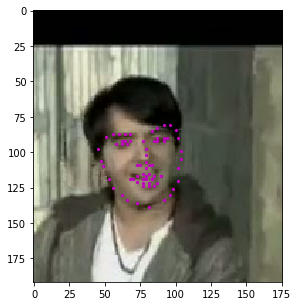

In [183]:
image_name = key_pts_frame.iloc[0,0]
plt.figure(figsize=(5, 5))
show_image(mpimg.imread(os.path.join('data/train-test-data/training/', image_name)), key_pts_0)
plt.show()

## Data Block API

This isn't a particulary large dataset but it's possible that in the machine that I have it's possible for my RAM to be exceeded. So instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them.

In [48]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

In [49]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [55]:
#export
class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    def new(self, items): return self.__class__(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)


In [54]:
#export
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

In [56]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [57]:
#export
class MakeGray(Transform):
    def __call__(self,item): return item.convert('LA')
    

In [60]:
#export
from torch.utils.data import Dataset,DataLoader

In [61]:
#export
class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

## Transforms

In [184]:
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        print(type(image))
        #image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        image_copy = PIL.Image.fromarray(image)

        # convert image to grayscale
        #image_copy_RGB = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #image_copy = cv2.cvtColor(image, cv2.cv2.COLOR_RGB2GRAY)
        #image_copy = PIL.Image.fromarray(image_copy)
        image_copy = image_copy.convert('LA')
        image_copy = np.array(image_copy)
        image_copy=  image_copy/255.0
        if(image_copy.shape[2] == 2):
            image_copy = image_copy[:,:,0]
            
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}

In [185]:
norm_0 = Normalize()({'image':mpimg.imread(os.path.join('data/train-test-data/training/', image_name)),'keypoints':key_pts_0})

<class 'numpy.ndarray'>


In [186]:
norm_image = Normalize()({'image':mpimg.imread(os.path.join('data/train-test-data/training/', image_name)),'keypoints':key_pts_0})['image']

<class 'numpy.ndarray'>


In [187]:
norm_image.shape

(192, 176)

In [188]:
norm_image

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.38431373, 0.38823529, 0.36862745, ..., 0.43921569, 0.43921569,
        0.43921569],
       [0.38039216, 0.39215686, 0.38823529, ..., 0.44313725, 0.44313725,
        0.43921569],
       [0.38431373, 0.4       , 0.40392157, ..., 0.44705882, 0.44705882,
        0.44313725]])

<class 'numpy.ndarray'>


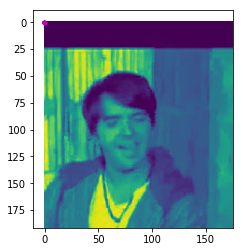

In [189]:
plt.imshow(Normalize()({'image':mpimg.imread(os.path.join('data/train-test-data/training/', image_name)),'keypoints':key_pts_0})['image'])
plt.scatter(norm_0['keypoints'][:,0],norm_0['keypoints'][:,1],s=20,marker='.',c='m')

In [65]:
transformed_dataset = FacialKeypointsDataset(csv_file='data/train-test-data/training_frames_keypoints.csv',
                                             root_dir='data/train-test-data/training/',
                                             transform=None)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
#for i in range(4):
#    sample = transformed_dataset[i]
#   print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462


Maybe using dataset and dataloader method might work

In [67]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))